In [928]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [929]:
horizon = 30
number_days = 0

# Define the window sizes for the moving averages
short_window = 30  # Short-term moving average
long_window = 60 # Long-term moving average

buy_cutoff = 1
sell_cutoff = -1


In [930]:
# Load the CSV file into a DataFrame
file_path_1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv' # Daily technical data (CRSP)
file_path_2 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_q_data_alltime.csv' # Fundamental data (Compustat)
file_path_3 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_quarterly_ratiodata_alltime.csv' # Fundamental ratios (Compustat)

df1 = pd.read_csv(file_path_1)
df2 = pd.read_csv(file_path_2)
df3 = pd.read_csv(file_path_3)

#Convert date columns to datetime format
df1['date'] = pd.to_datetime(df1['date'])  # CRSP daily data
df2['datadate'] = pd.to_datetime(df2['datadate'])  # Fundamental data
df3['qdate'] = pd.to_datetime(df3['qdate'])  # Financial ratios data



In [944]:
# QUARTERLY PERCENTAGE CHANGES

# Make a copy of df2 to avoid modifying the original data
df2_pct = df2.copy()

# Identify numeric columns that should be converted to percentage changes
# Exclude non-numeric columns such as 'gvkey', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc', 'datafmt', 'tic', 'curcdq', 'datacqtr', 'datafqtr', 'costat'
columns_to_change = ['epsfxq', 'ltq', 'niq', 'revtq', 'capxy']
# Apply pct_change to each selected column and multiply by 100 to express as percentage
df2_pct[columns_to_change] = df2[columns_to_change].pct_change() * 100

# Sort by qdate and public_date to ensure the most recent public_date comes last
df3_sorted = df3.sort_values(by=['qdate', 'public_date'])
# Drop duplicates to keep only the latest public_date for each qdate
df3_latest = df3_sorted.drop_duplicates(subset='qdate', keep='last')

# Make a copy to avoid modifying the original df3_latest
df3_latest_pct = df3_latest.copy()

# Select columns to calculate percentage change, excluding identifier and date columns
columns_to_change = ['npm', 'de_ratio', 'curr_ratio', 'ptb'] # Apply pct_change to each selected column and multiply by 100 to express as percentage
df3_latest_pct[columns_to_change] = df3_latest[columns_to_change].pct_change() * 100





/var/folders/2f/bmcm36r135v_v27k0vz0w_dr0000gn/T/ipykernel_21700/4258325940.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df2_pct[columns_to_change] = df2[columns_to_change].pct_change() * 100


In [932]:
# First merge daily technical data (df1) with fundamental data (df2)
# Merge on the nearest quarter date for Exxon
df_combined_1_2 = pd.merge_asof(
    df1,  # Daily data sorted by date
    df2_pct,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='datadate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Now merge with the cleaned financial ratios (df3_latest)
df_combined_all = pd.merge_asof(
    df_combined_1_2.sort_values('date'),  # Combined data sorted by date
    df3_latest_pct.sort_values('qdate'),  # Financial ratios sorted by quarterly date
    left_on='date', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Display the first few rows of the final combined dataset


In [933]:
# Filter the DataFrame to remove unnecessary/repeated collumns
columns_to_keep = [
    'date', 
    'PRC', 
    'epsfxq', 'ltq', 'niq', 'revtq', 
    'capxy', 'npm', 'de_ratio', 'curr_ratio', 'ptb'
]
df_filtered = df_combined_all[columns_to_keep]

# Define new names for columns to make them more understandable
column_renames = {
    'date': 'Date', 
    'PRC': 'Price', 
    'epsfxq': 'Earnings_Per_Share', 
    'ltq': 'Long_Term_Debt', 
    'niq': 'Net_Income', 
    'revtq': 'Revenue', 
    'capxy': 'Capital_Expenditure', 
    'npm': 'Net_Profit_Margin', 
    'de_ratio': 'Debt_Equity_Ratio', 
    'curr_ratio': 'Current_Ratio', 
    'ptb': 'Price_To_Book_Ratio'
}

# Apply the filter and rename the columns
df_filtered = df_combined_all[columns_to_keep].rename(columns=column_renames)

# Calculate the percentage change in price over the time horizon
df_filtered['Horizon_Percent_Change'] = (
    (df_filtered['Price'].shift(-1 * horizon) - df_filtered['Price']) / df_filtered['Price'] * 100
)

# Move the 'Price' column to the end of the DataFrame
price_col = df_filtered.pop('Price')
df_filtered['Price'] = price_col

# Display the first few rows of the renamed DataFrame



In [934]:


# Calculate moving averages and add them as new columns
df_filtered['Short_MA'] = df_filtered['Price'].rolling(window=short_window, min_periods=1).mean()
df_filtered['Long_MA'] = df_filtered['Price'].rolling(window=long_window, min_periods=1).mean()

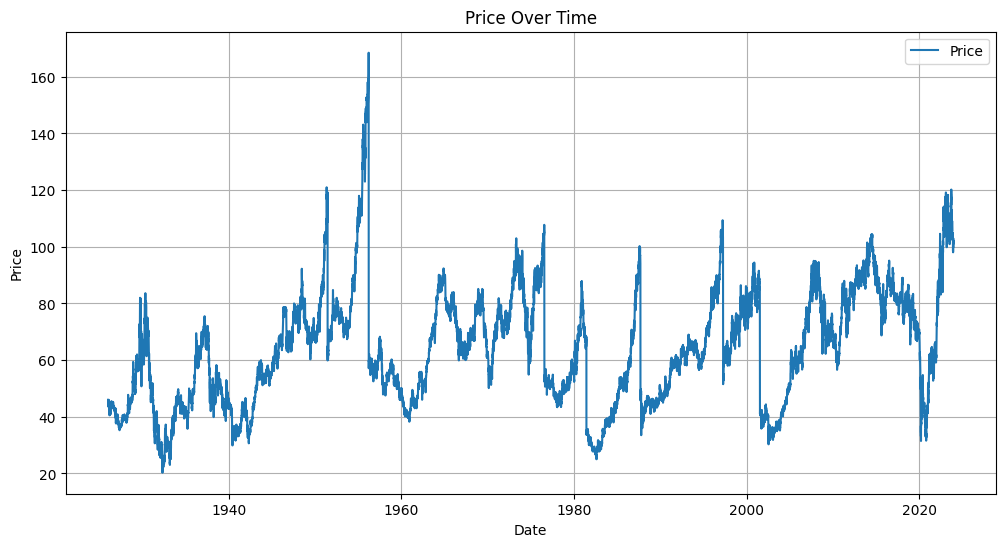

In [935]:
import matplotlib.pyplot as plt

# Plot Price over time
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Date'], df_filtered['Price'], label='Price', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [936]:
# Calculate percentage change for 'Price' and replace it
#df_filtered['Price'] = df_filtered['Price'].pct_change() * 100

# Add price of previous days as features containing the percentage change from that day to the current day
for i in range(1, number_days + 1):  # Start from 1 to avoid having a column with no shift (i.e., Price_Day_0)
    df_filtered[f'Price_Day_{i}'] = ((df_filtered['Price'] - df_filtered['Price'].shift(i)) / df_filtered['Price'].shift(i)) * 100

price_col = df_filtered.pop('Price')

# Remove rows with NaN values that may have been introduced by shifting
df_filtered.dropna(inplace=True)

# Assign the modified DataFrame back to df
df = df_filtered

# Print the first row to check the structure
print(df.head(1))

            Date  Earnings_Per_Share  Long_Term_Debt  Net_Income   Revenue  \
15844 1984-07-02           -6.857143       -0.755212   -8.474576 -3.736997   

       Capital_Expenditure  Net_Profit_Margin  Debt_Equity_Ratio  \
15844           173.708069           3.333333           0.175593   

       Current_Ratio  Price_To_Book_Ratio  Horizon_Percent_Change   Short_MA  \
15844       -1.11465            11.981567                0.613497  40.466667   

         Long_MA  
15844  41.027083  


In [937]:
# Prepare the features and target
fundamental_features = [
    'Earnings_Per_Share', 
    'Long_Term_Debt', 
    'Net_Income', 
    'Revenue', 
    'Capital_Expenditure', 
    'Net_Profit_Margin', 
    'Debt_Equity_Ratio', 
    'Current_Ratio',
    'Price_To_Book_Ratio'
]

In [938]:

# Split data into training/validation and test sets based on dates
train_val_start_date = '2002-01-31'
test_start_date = '2014-08-31'
test_end_date = '2016-08-31'

# Train/val data ends 1 month before test data starts
train_val_end_date = pd.to_datetime(test_start_date) - pd.Timedelta(days=horizon)
train_val_data = df[(df['Date'] >= train_val_start_date) & (df['Date'] < train_val_end_date)]
test_data = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)]

# Split the data into features (X) and target (y)
X_train_val = train_val_data.drop(columns=['Date', 'Horizon_Percent_Change'] + fundamental_features)
y_train_val = train_val_data['Horizon_Percent_Change']
X_test = test_data.drop(columns=['Date', 'Horizon_Percent_Change'] + fundamental_features)
y_test = test_data['Horizon_Percent_Change']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training/validation data
X_train_val_scaled = scaler.fit_transform(X_train_val)

# Now apply the same scaling to the test data using the already fitted scaler
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_val_scaled = pd.DataFrame(X_train_val_scaled, columns=X_train_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Split the training/validation data into training and validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val_scaled, y_train_val, test_size=0.2, random_state=42)

X_train.head()

,Short_MA,Long_MA
2307,0.804472,0.720456
1512,1.089372,1.095076
2868,1.185920,1.153980
2985,1.295002,1.164013
221,-1.729688,-1.741311


In [939]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and Evaluation on Training Set
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Predictions and Evaluation on Validation Set
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Predictions and Evaluation on Test Set
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Baseline Model: Mean Prediction
# Compute the mean of the training target
mean_train_target = y_train.mean()

# Use this mean as the prediction for all validation and test data points
y_val_baseline = np.full_like(y_val, fill_value=mean_train_target)
y_test_baseline = np.full_like(y_test, fill_value=mean_train_target)

# Baseline evaluation for validation set
val_baseline_rmse = np.sqrt(mean_squared_error(y_val, y_val_baseline))

# Baseline evaluation for test set
test_baseline_rmse = np.sqrt(mean_squared_error(y_test, y_test_baseline))

print(f"Baseline Validation RMSE: {val_baseline_rmse:.4f}")
print(f"Baseline Test RMSE: {test_baseline_rmse:.4f}")


# Calculate the percentage of correct sign predictions for the test set
correct_signs = np.sign(y_test) == np.sign(y_test_pred)
percentage_correct_signs = np.mean(correct_signs) * 100

# Print the percentage of correct sign predictions
print(f"Percentage of Correct Sign Predictions: {percentage_correct_signs:.2f}%")

Train RMSE: 6.2129
Validation RMSE: 6.1573
Test RMSE: 5.8297
Baseline Validation RMSE: 6.2038
Baseline Test RMSE: 6.0714
Percentage of Correct Sign Predictions: 48.71%


In [940]:
# Initialize and train the Ridge Regression model with a specified alpha (regularization strength)
alpha = 0.4  # You can adjust this value to see how it affects performance
model = Ridge(alpha=alpha)
model.fit(X_train, y_train)

# Predictions and Evaluation on Training Set
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Predictions and Evaluation on Validation Set
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Predictions and Evaluation on Test Set
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Calculate the percentage of correct sign predictions for the test set
correct_signs = np.sign(y_test) == np.sign(y_test_pred)
percentage_correct_signs = np.mean(correct_signs) * 100

# Print the percentage of correct sign predictions
print(f"Percentage of Correct Sign Predictions: {percentage_correct_signs:.2f}%")

Train RMSE: 6.2129
Validation RMSE: 6.1576
Test RMSE: 5.8300
Percentage of Correct Sign Predictions: 49.11%


In [941]:
# Initialize and train the Lasso Regression model with a specified alpha
alpha = 0.04  # You can adjust this value as needed
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)

# Predictions and Evaluation on Training Set
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Predictions and Evaluation on Validation Set
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Predictions and Evaluation on Test Set
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 6.2255
Validation RMSE: 6.1762
Test RMSE: 5.8609


In [942]:
#SIGNS

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Baseline Test RMSE: {test_baseline_rmse:.4f}")
print("")

total_samples = len(y_test)
print(f"Total Samples: {total_samples}")

# Calculate the percentage of true targets that are positive
total_positive_samples = np.sum(y_test > 0)
percentage_true_positive = np.mean(y_test > 0) * 100
# Print the percentage of true positive targets
print(f"Positive Targets: {total_positive_samples} ({percentage_true_positive:.2f}%)")

# Calculate the percentage of correct sign predictions for the test set
correct_signs = np.sign(y_test) == np.sign(y_test_pred)
percentage_correct_signs = np.mean(correct_signs) * 100
# Print the percentage of correct sign predictions
print(f"Percentage of Correct Sign Predictions: {percentage_correct_signs:.2f}%")
print("")

#BUYS

total_true_buys = np.sum(y_test > buy_cutoff)
percentage_true_buys = np.mean(y_test > buy_cutoff) * 100
# Print the percentage of true positive targets
print(f"{buy_cutoff}%+ Targets: {total_true_buys} ({percentage_true_buys:.2f}%)")

total_predicted_buys = np.sum(y_test_pred > buy_cutoff)
percentage_predicted_buys = np.mean(y_test_pred > buy_cutoff) * 100
# Print the percentage of true positive targets
print(f"{buy_cutoff}%+ Predictions: {total_predicted_buys} ({percentage_predicted_buys:.2f}%)")

# Identify cases where the predicted value is at least x
predicted_at_least_x = y_test_pred >= buy_cutoff
# Count how many of these cases have a true value that is at least zero
true_values_at_least_x = y_test >= buy_cutoff
# Calculate the number of cases where the predicted value is at least 5 and the true value is non-negative
correct_cases_count = np.sum(true_values_at_least_x[predicted_at_least_x])
total_cases_count = np.sum(predicted_at_least_x)
# Calculate the percentage
percentage_true_x = (correct_cases_count / total_cases_count * 100) if total_cases_count > 0 else 0
# Print the result
print(f"Percentage of >{buy_cutoff}%+ Target when Predicted Value >= {buy_cutoff}%: {percentage_true_x:.2f}%")


# Count how many of these cases have a true value that is at least zero
true_values_non_negative = y_test >= 0
# Calculate the number of cases where the predicted value is at least 5 and the true value is non-negative
correct_cases_count = np.sum(true_values_non_negative[predicted_at_least_x])
total_cases_count = np.sum(predicted_at_least_x)
# Calculate the percentage
percentage_true_non_negative = (correct_cases_count / total_cases_count * 100) if total_cases_count > 0 else 0
# Print the result
print(f"Percentage of Positive Target when Predicted Value >= {buy_cutoff}%: {percentage_true_non_negative:.2f}%")
print("")

#SELLS 

total_true_sells = np.sum(y_test < sell_cutoff)
percentage_true_sells = np.mean(y_test < sell_cutoff) * 100
# Print the percentage of true positive targets
print(f"{sell_cutoff}% Targets: {total_true_sells} ({percentage_true_sells:.2f}%)")

total_predicted_sells = np.sum(y_test_pred < sell_cutoff)
percentage_predicted_sells = np.mean(y_test_pred < sell_cutoff) * 100
# Print the percentage of true positive targets
print(f"{sell_cutoff}% Predictions: {total_predicted_sells} ({percentage_predicted_sells:.2f}%)")

# Identify cases where the predicted value is at least x
predicted_at_least_x = y_test_pred <= sell_cutoff
# Count how many of these cases have a true value that is at least zero
true_values_at_least_x = y_test <= sell_cutoff
# Calculate the number of cases where the predicted value is at least 5 and the true value is non-negative
correct_cases_count = np.sum(true_values_at_least_x[predicted_at_least_x])
total_cases_count = np.sum(predicted_at_least_x)
# Calculate the percentage
percentage_true_x = (correct_cases_count / total_cases_count * 100) if total_cases_count > 0 else 0
# Print the result
print(f"Percentage of <{sell_cutoff}% Target when Predicted Value < {sell_cutoff}%: {percentage_true_x:.2f}%")


# Count how many of these cases have a true value that is at least zero
true_values_negative = y_test <= 0
# Calculate the number of cases where the predicted value is at least 5 and the true value is non-negative
correct_cases_count = np.sum(true_values_negative[predicted_at_least_x])
total_cases_count = np.sum(predicted_at_least_x)
# Calculate the percentage
percentage_true_non_negative = (correct_cases_count / total_cases_count * 100) if total_cases_count > 0 else 0
# Print the result
print(f"Percentage of Negative Target when Predicted Value < {sell_cutoff}%: {percentage_true_non_negative:.2f}%")
print("")

Train RMSE: 6.2255
Validation RMSE: 6.1762
Test RMSE: 5.8609
Baseline Test RMSE: 6.0714

Total Samples: 505
Positive Targets: 226 (44.75%)
Percentage of Correct Sign Predictions: 47.33%

1%+ Targets: 206 (40.79%)
1%+ Predictions: 0 (0.00%)
Percentage of >1%+ Target when Predicted Value >= 1%: 0.00%
Percentage of Positive Target when Predicted Value >= 1%: 0.00%

-1% Targets: 255 (50.50%)
-1% Predictions: 0 (0.00%)
Percentage of <-1% Target when Predicted Value < -1%: 0.00%
Percentage of Negative Target when Predicted Value < -1%: 0.00%



In [943]:
y_test = y_test.reset_index(drop=True)

# Create a DataFrame for easier plotting and comparison
results = pd.DataFrame({'Predicted': y_test_pred, 'Actual': y_test}, index=X_test.index)

# Filter the results for buy or sell cases
results = results[(results['Predicted'] >= buy_cutoff) | (results['Predicted'] <= 0)]

# Shuffle the filtered results before printing
#shuffled_results = results.sample(frac=1, random_state=42)

# Print the shuffled filtered results (first 20 rows)
print(results.head(20))



    Predicted    Actual
0   -0.097331 -8.061732
1   -0.092106 -8.969832
2   -0.085161 -7.889386
3   -0.079241 -8.110014
4   -0.072861 -6.136852
5   -0.064630 -3.840230
6   -0.056681 -3.801260
7   -0.049346 -3.009379
8   -0.045620 -1.346837
9   -0.042660 -2.679406
10  -0.039476 -2.391461
11  -0.038155 -2.564895
12  -0.035360 -2.235793
13  -0.034004 -0.422158
14  -0.030230 -1.325875
15  -0.027046 -1.572425
16  -0.023898 -0.782718
17  -0.018190  2.132626
18  -0.013874  1.215551
19  -0.008449  1.959123
